# **UPLIFT MODELING**


*   Uplift models are designed to determine the incremental impact of a treatment or intervention.
*   Unlike standard response models, which simply predict the likelihood of an event (e.g., making a purchase) after an intervention (e.g., seeing an advertisement), uplift models gauge the incremental change in that likelihood due to the intervention itself.
*   For instance, while a traditional response model might tell us that a person is inclined to make a purchase after viewing an advertisement, it doesn’t differentiate between those who were already predisposed to purchase without the ad and those truly influenced by it.
*   In contrast, uplift models specifically measure the boost in probability of the event resulting directly from the intervention, helping businesses to discern the genuine effect of their actions.




# **About the Data**

**clientID**: Unique ID to identify customer

**gender**: Gender of customer

**age**: Age of customer

**zipCodeCat**: Zipcode category of customer (Urban/ Suburban/ Rural)

**isReferral**: Indication to whether the customer
was acquired via a referral channel

**salesChannel**: channels used by customer (Phone/ Web/ MultiChannel)

**totalAmountSpend**: Total value of historical
purchases during the last year

**daysSinceLastPurchase**: Days since last purchase

**usedDiscount**: Indicates if the customer used a discount before

**usedBOGO**: Indicates if the customer used a buy one get one offer before

**treatment**: Offers sent to the customers

**visit**: Indicates whether the customer visted the
website/app after offer was sent (2 week period)

**conversion**: Indicates customer conversion (2 week period)

**spend**: Indicates amount spend  (2 week period)

In [3]:
# Import data
import pandas as pd
df_data = pd.read_csv('data/customer_data.csv')
df_data = df_data.iloc[:5000]  ##### I trained this model only for 5000 data due to hughe computation power.
df_model = df_data.copy()
df_model = df_model.iloc[:5000]
df_model.head()

,clientID,gender,age,zipCodeCat,isReferral,salesChannel,totalAmountSpend,daysSinceLastPurchase,usedDiscount,usedBOGO,treatment,visit,conversion,spend
0,004dc888-f528-49c4-ae94-f3ea4f2a65c7,Male,49,Surburban,No,Phone,142.44,282,1,0,BOGO,1,0,0.0
1,b74ce820-9372-4b2e-ad0f-8eb9f9fe582c,Female,68,Rural,Yes,Web,329.08,162,1,1,No Offer,1,0,0.0
2,e55fb273-e422-4da0-bf2c-b30982ce8484,Female,52,Surburban,Yes,Web,180.65,183,0,1,BOGO,1,0,0.0
3,81646989-a0af-4e28-9571-d2a6b77b493a,Female,60,Rural,Yes,Web,675.83,267,1,0,Discount,0,0,0.0
4,e1cbdac4-cc40-4a97-b5c3-55a342ae210a,Male,45,Urban,No,Web,45.34,41,1,0,BOGO,0,0,0.0


# **Requirement**

1. Can we model the uplift (conversion) of customers?
2. Can we segment customers in a meaningful way?

* Clearly explain the steps & assumptions (using markdown etc.) you took while solving the above problems.

# importing necessary modules

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import matplotlib as mpl

# Exploring Data

In [5]:
df_model.describe()

,age,totalAmountSpend,daysSinceLastPurchase,usedDiscount,usedBOGO,visit,conversion,spend
count,5000.000000,4987.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,52.169200,243.583603,160.717200,0.557200,0.548800,0.574200,0.142600,2.047556
std,13.828102,260.010533,106.078208,0.496767,0.497663,0.494513,0.349699,7.603975
min,18.000000,29.990000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,65.405000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,158.620000,155.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,68.000000,324.445000,262.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,68.000000,3345.930000,360.000000,1.000000,1.000000,1.000000,1.000000,100.820000


In [6]:
import numpy as np
df_model.describe(include=np.object)

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/294362160.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_model.describe(include=np.object)


,clientID,gender,zipCodeCat,isReferral,salesChannel,treatment
count,4995,5000,4991,5000,5000,5000
unique,4995,2,3,2,3,3
top,004dc888-f528-49c4-ae94-f3ea4f2a65c7,Male,Surburban,Yes,Web,BOGO
freq,1,2536,2238,2518,2208,1697


In [7]:
cat_features = [col for col in df_model.columns if df_model[col].dtype == 'object']
for c in cat_features:
    print('----')
    print(df_model[c].value_counts())

----
004dc888-f528-49c4-ae94-f3ea4f2a65c7    1
09393ab9-a48e-44ec-933a-36f3fdd16e3e    1
69715761-e77f-429b-b2dc-f69d0a5a38a2    1
35c086a7-1cc8-4863-a1ce-dd1f055451f8    1
a3060123-73a6-4230-be5c-ded767ac5015    1
                                       ..
6d1037ce-2167-4067-8624-2860f1f6cd70    1
eec78595-09f3-432d-a104-bc7e68df6292    1
4c0b6214-02b0-42ef-b51f-b978adc0f0fb    1
f07cebb1-cef6-499f-a659-de440624c8a5    1
02230160-e796-4cac-9766-3cd9677da310    1
Name: clientID, Length: 4995, dtype: int64
----
Male      2536
Female    2464
Name: gender, dtype: int64
----
Surburban    2238
Urban        2044
Rural         709
Name: zipCodeCat, dtype: int64
----
Yes    2518
No     2482
Name: isReferral, dtype: int64
----
Web             2208
Phone           2202
Multichannel     590
Name: salesChannel, dtype: int64
----
BOGO        1697
No Offer    1660
Discount    1643
Name: treatment, dtype: int64


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

In [9]:
cat_cols, num_cols, cat_but_car=grab_col_names(df_model)

Observations: 5000
Variables: 14
num_cols: 4
cat_but_car: 1


In [10]:
def cat_summary(dataframe, col_name, plot=False):
    mpl.rcParams['figure.dpi'] = 75 ## <===== for see figures in small size in vs code. Since i used vs code for coding.
    if plot:
        colors = ["#202240","#F5801A","#808080","#838496"]
        # sns.set_palette(sns.color_palette(colors))
        sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
        plt.show()

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


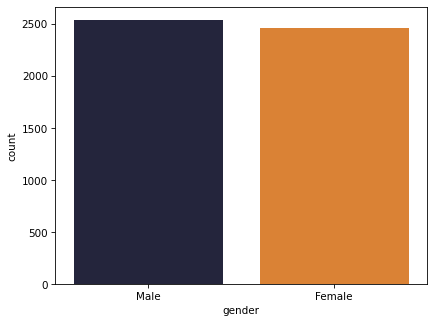

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: 
The palette list has fewer values (4) than needed (44) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


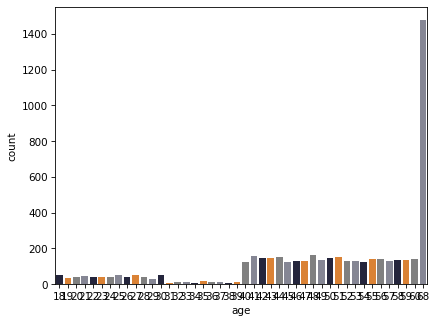

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


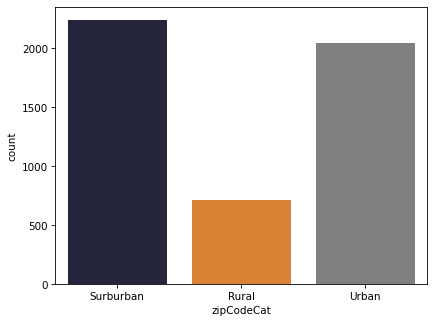

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


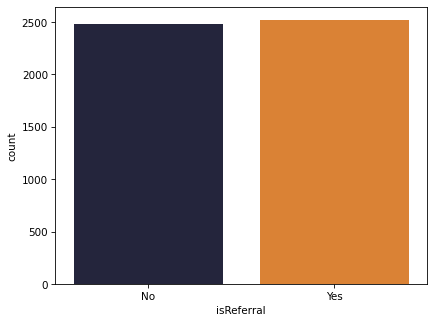

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


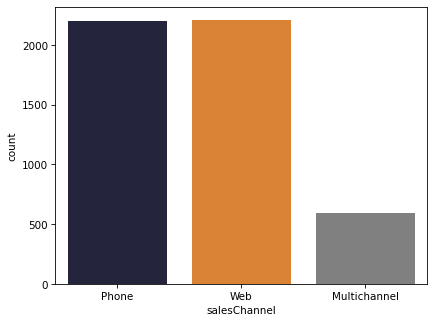

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


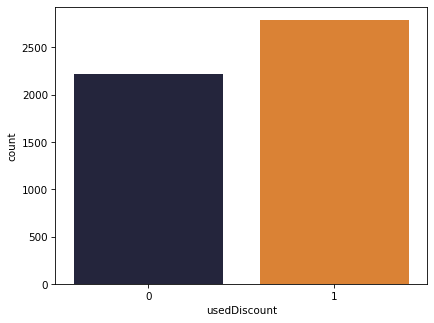

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


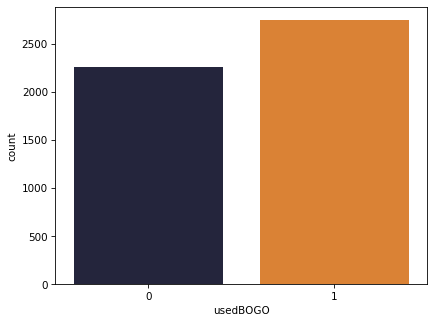

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


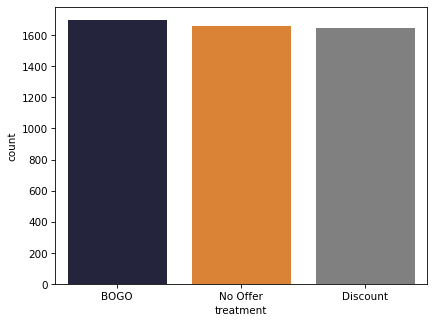

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


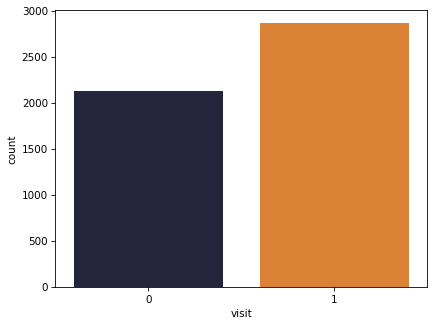

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)
/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/2786472259.py:6: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x=dataframe[col_name], data=dataframe, palette=colors)


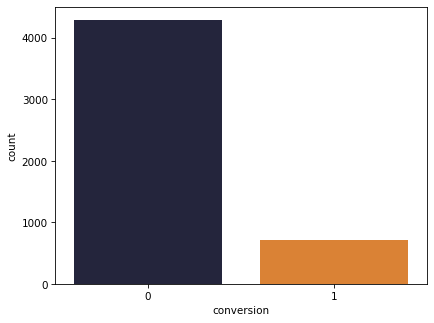

In [11]:
for col in ['gender','age','zipCodeCat','isReferral', 'salesChannel','usedDiscount','usedBOGO','treatment','visit','conversion']:
    cat_summary(df_data, col, plot=True)

# Preprocessing

In [12]:
# Rename target column
df_model = df_model.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'BOGO': -1, 'Discount': 1})

In [13]:
df_model.treatment.value_counts()

-1    1697
 0    1660
 1    1643
Name: treatment, dtype: int64

In [14]:
df_model.target.value_counts()

0    4287
1     713
Name: target, dtype: int64

In [15]:
df_model.treatment.unique()

array([-1,  0,  1])

In [16]:
df_model.head()

,clientID,gender,age,zipCodeCat,isReferral,salesChannel,totalAmountSpend,daysSinceLastPurchase,usedDiscount,usedBOGO,treatment,visit,target,spend
0,004dc888-f528-49c4-ae94-f3ea4f2a65c7,Male,49,Surburban,No,Phone,142.44,282,1,0,-1,1,0,0.0
1,b74ce820-9372-4b2e-ad0f-8eb9f9fe582c,Female,68,Rural,Yes,Web,329.08,162,1,1,0,1,0,0.0
2,e55fb273-e422-4da0-bf2c-b30982ce8484,Female,52,Surburban,Yes,Web,180.65,183,0,1,-1,1,0,0.0
3,81646989-a0af-4e28-9571-d2a6b77b493a,Female,60,Rural,Yes,Web,675.83,267,1,0,1,0,0,0.0
4,e1cbdac4-cc40-4a97-b5c3-55a342ae210a,Male,45,Urban,No,Web,45.34,41,1,0,-1,0,0,0.0


In [17]:
df_model = pd.get_dummies(df_model)
df_model.head()

,age,totalAmountSpend,daysSinceLastPurchase,usedDiscount,usedBOGO,treatment,visit,target,spend,clientID_000fc343-6b4c-49b3-9b4a-27cc6cf0335c,...,gender_Female,gender_Male,zipCodeCat_Rural,zipCodeCat_Surburban,zipCodeCat_Urban,isReferral_No,isReferral_Yes,salesChannel_Multichannel,salesChannel_Phone,salesChannel_Web
0,49,142.44,282,1,0,-1,1,0,0.0,0,...,0,1,0,1,0,1,0,0,1,0
1,68,329.08,162,1,1,0,1,0,0.0,0,...,1,0,1,0,0,0,1,0,0,1
2,52,180.65,183,0,1,-1,1,0,0.0,0,...,1,0,0,1,0,0,1,0,0,1
3,60,675.83,267,1,0,1,0,0,0.0,0,...,1,0,1,0,0,0,1,0,0,1
4,45,45.34,41,1,0,-1,0,0,0.0,0,...,0,1,0,0,1,1,0,0,0,1


In [18]:
df_model.mean()

age                           52.169200
totalAmountSpend             243.583603
daysSinceLastPurchase        160.717200
usedDiscount                   0.557200
usedBOGO                       0.548800
                                ...    
isReferral_No                  0.496400
isReferral_Yes                 0.503600
salesChannel_Multichannel      0.118000
salesChannel_Phone             0.440400
salesChannel_Web               0.441600
Length: 5014, dtype: float64

In [19]:
df_model_bogo = df_model[df_model.treatment <= 0] # include no offer, bogo
df_model_discount = df_model[df_model.treatment >= 0] # include no offer, discount

In [20]:
temp_df = df_model_bogo.mean()

In [21]:
pd.DataFrame({"mean":df_model_bogo.groupby("target")['age'].mean()})

,mean
target,
0,59.214384
1,30.141876


In [22]:
import matplotlib as mpl

def target_summary(dataframe, target, numerical_col,plot=True):
    mpl.rcParams['figure.dpi'] = 75 ## <===== for see figures in small size in vs code. Since i used vs code for coding.
    data=pd.DataFrame({"mean":dataframe.groupby(target)[numerical_col].mean()})
    print(data,end="\n\n\n\n")
    if plot:
        colors = ["#202240","#F5801A"]
        plt.figure(figsize=(5, 5))
        ax = sns.barplot(x='target', y='mean', hue='target', data=data, width=0.3,palette=colors)
        ax.spines[['top', 'right']].set_visible(False)
        sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
        ax.set(ylabel =numerical_col+" average", title =numerical_col)
        plt.show() 

             mean
target           
0       59.214384
1       30.141876





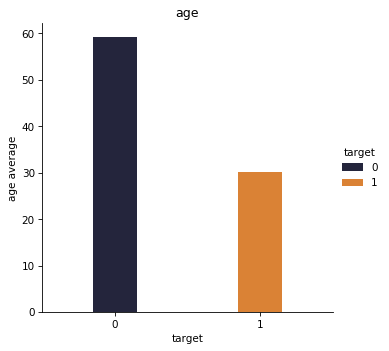

              mean
target            
0       241.640597
1       278.275586





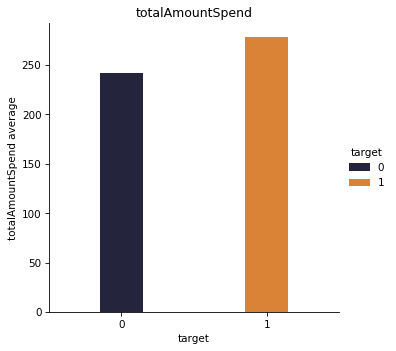

              mean
target            
0       163.497603
1       135.048055





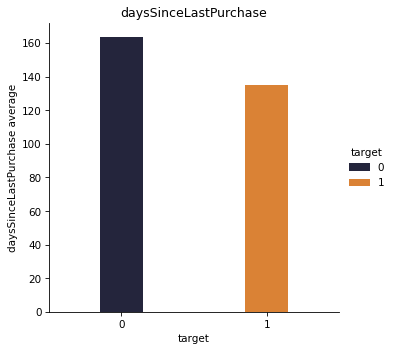

            mean
target          
0       0.556507
1       0.528604





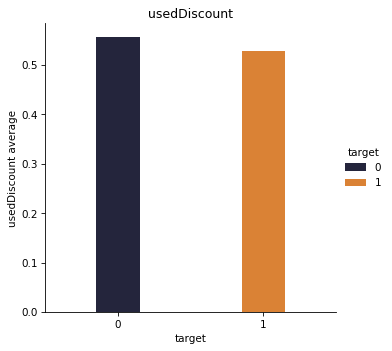

            mean
target          
0       0.537671
1       0.622426





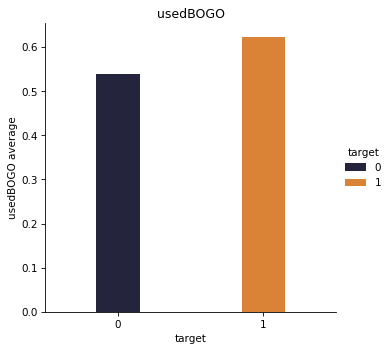

            mean
target          
0      -0.494178
1      -0.581236





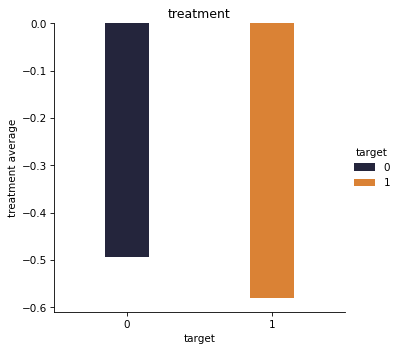

            mean
target          
0       0.505137
1       1.000000





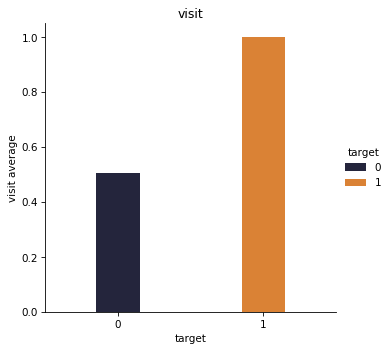

             mean
target           
0        0.000000
1       14.222677





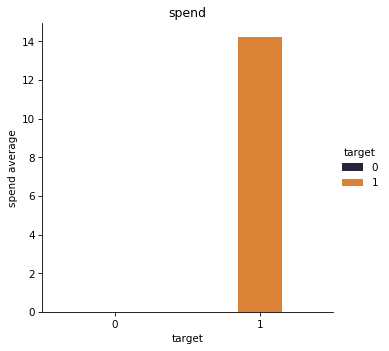

In [23]:
cols = ['age',	'totalAmountSpend'	, 'daysSinceLastPurchase',	'usedDiscount', 'usedBOGO', 'treatment', 'visit', 'spend']
for col in cols:
    target_summary(df_model_bogo,"target",col,plot=True)

# Declaring target class

In [24]:
def declare_tc(df:pd.DataFrame):
    df['target_class'] = 0 # CN
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 # CR
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 # TN
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 # TR
    return df

In [25]:
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/1746252929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_class'] = 0 # CN
/Users/chiransiriwardena/miniconda3/envs/test1/lib/python3.11/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [26]:
df_model_bogo['target_class'].value_counts()

0    1477
2    1443
3     254
1     183
Name: target_class, dtype: int64

# Modeling (Uplift)

In [27]:

from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    ## Train-Test Split
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model ( Use XGBoost)
    uplift_model = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    X_train = X_train.drop('treatment', axis=1)
    
    importances = uplift_model.feature_importances_
    # Predict data
    uplift_proba = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')  
    # add result
    result['target_class'] = y_test
    return result, importances, X_train


def uplift(df_model:pd.DataFrame):
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result, importances,X_train = uplift_model(X_train, X_test, y_train, y_test)
    return result,importances,X_train

In [28]:
# Run the uplift function
bogo_uplift,importances,X_train = uplift(df_model_bogo)
discount_uplift, importances,X_train = uplift(df_model_discount)

In [29]:
bogo_uplift.head()

,age,totalAmountSpend,daysSinceLastPurchase,usedDiscount,usedBOGO,treatment,visit,spend,clientID_000fc343-6b4c-49b3-9b4a-27cc6cf0335c,clientID_00183ee7-6046-4558-b614-2634acc31201,...,isReferral_Yes,salesChannel_Multichannel,salesChannel_Phone,salesChannel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
4229,46,176.41,164,1,0,0,1,8.84,0,0,...,0,0,0,1,0.000164,0.998830,0.000473,0.000533,-0.940352,1
476,38,114.74,153,1,0,0,1,5.00,0,0,...,0,0,0,1,0.001723,0.995842,0.001782,0.000653,-1.460260,1
1686,42,171.20,15,0,1,-1,1,0.00,0,0,...,0,0,0,1,0.000489,0.000317,0.998986,0.000208,-0.785325,2
3337,68,53.56,173,0,1,0,1,0.00,0,0,...,0,0,0,1,0.999495,0.000075,0.000250,0.000179,0.835222,0
2,52,180.65,183,0,1,-1,1,0.00,0,0,...,1,0,0,1,0.000208,0.000066,0.999559,0.000167,-0.481366,2


# Plotting feature importance

[7.9491019e-01 2.6829825e-03 3.9263060e-03 ... 0.0000000e+00 3.4867637e-03
 4.4665352e-04]


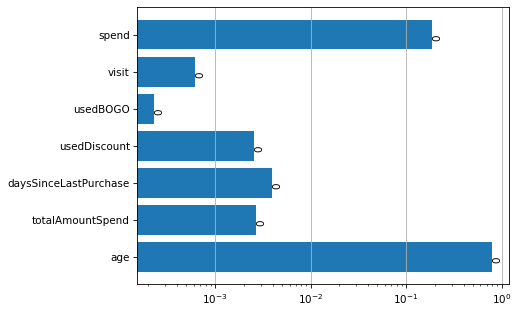

In [30]:
print(importances)

# since some features importance are very small, they have ignored
#plotting log scale
data = [importances[0], importances[1], importances[2], importances[3],importances[4], importances[5], importances[6]]
y = np.arange(len(data))
fig, ax = plt.subplots()
ax.barh(y,data)
ax.xaxis.grid()
ax.set_yticks(y)
ax.set_yticklabels(['age', 'totalAmountSpend', 'daysSinceLastPurchase', 'usedDiscount', 'usedBOGO', 'visit', 'spend'])

for i in range(len(data)):
    ax.text(data[i], y[i]-0.1, f'{int(data[i])}', rotation=90)

ax.set_xscale('log')

# Segmentation

In [31]:
seg_df = df_data.merge(bogo_uplift.iloc[:,-6:], left_index=True, right_index=True)
seg_df['target'] = 0
seg_df['target'][seg_df.treatment != 'No Offer'] = 1

/var/folders/v0/j1t93gnd49n6rh85bd5wpq8h0000gn/T/ipykernel_5360/286725937.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df['target'][seg_df.treatment != 'No Offer'] = 1


In [32]:
seg_df.groupby('zipCodeCat').mean()[['target','uplift_score']]

,target,uplift_score
zipCodeCat,,
Rural,0.521127,-0.149130
Surburban,0.514477,0.012698
Urban,0.491566,-0.153443


In [33]:
seg_df.groupby('salesChannel').mean()[['target','uplift_score']]

,target,uplift_score
salesChannel,,
Multichannel,0.566929,-0.118311
Phone,0.480000,-0.006270
Web,0.513158,-0.135477


In [34]:
seg_df.groupby('usedDiscount').mean()[['target','uplift_score']]

,target,uplift_score
usedDiscount,,
0,0.510297,-0.040700
1,0.502627,-0.108025


In [35]:
seg_df.groupby('usedBOGO').mean()[['target','uplift_score']]

,target,uplift_score
usedBOGO,,
0,0.500000,-0.107009
1,0.511111,-0.054421


# Qini curve

In [36]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('ticks')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=5)
    plt.ylabel('Uplift',fontsize=5)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=5)
    ax.tick_params(labelsize=5)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

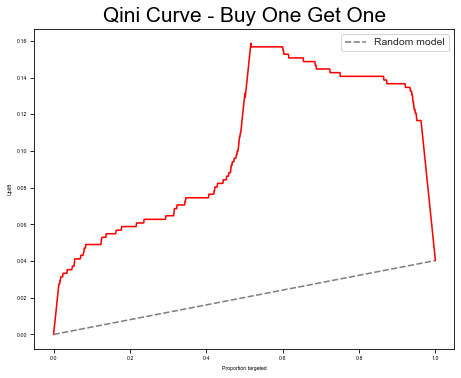

In [37]:
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

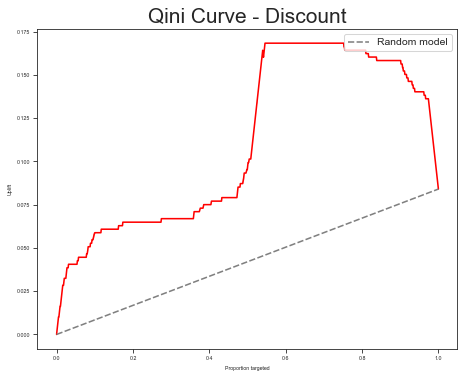

In [38]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)